# Plant Identification for Weed Control Project

## Libraries

In [1]:
import sys
import kagglehub
import warnings
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import os
import subprocess
import piexif
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

## Load Data

In [2]:
# Install kagglehub and tifffile silently (no output shown)
subprocess.call([sys.executable, "-m", "pip", "install", "kagglehub", "tifffile"],
                stdout=open(os.devnull, "w"), stderr=subprocess.STDOUT)

0

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)

# Download dataset locally
path = kagglehub.dataset_download("fpeccia/weed-detection-in-soybean-crops")
print("Path:", path)

Path: C:\Users\16302\.cache\kagglehub\datasets\fpeccia\weed-detection-in-soybean-crops\versions\1


## Data Preparation and Exploratory Data Analysis

           image_count
class                 
broadleaf         2150
grass             3520
soil              3249
soybean           7376


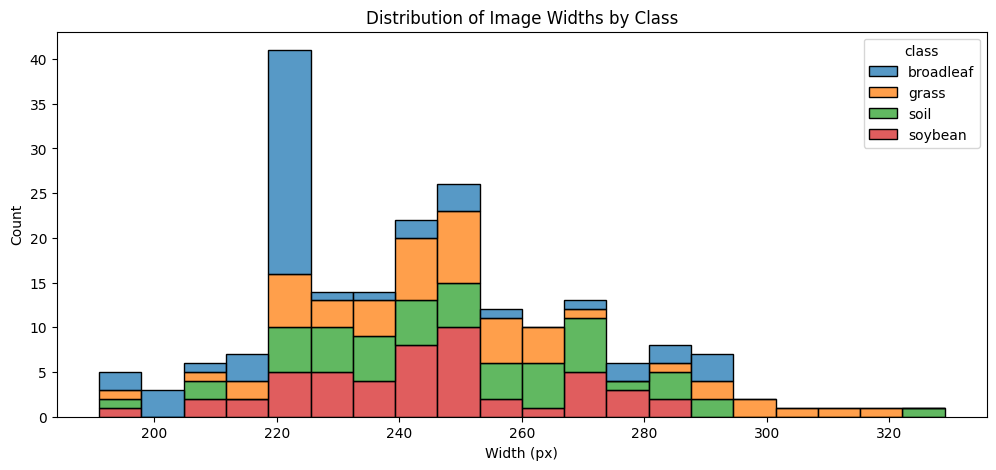

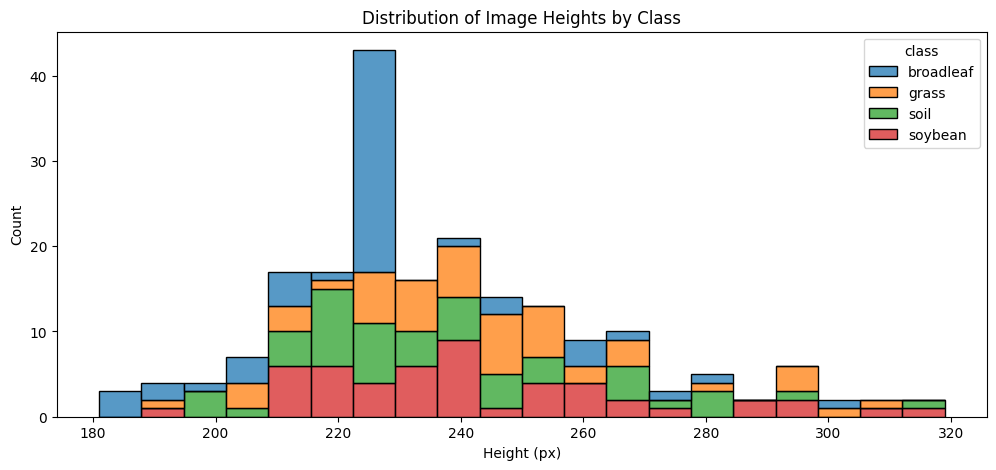

In [4]:
root = Path("C:/Users/16302/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1")
base = root / "dataset" / "dataset"
base_dir = base

# Define class labels from folder names
classes = sorted(p.name for p in base.iterdir() if p.is_dir())

# Resolution profiling: sample up to 50 images per class and record their sizes
records = []
for cls in classes:
    files = list((base/cls).iterdir())
    sample = random.sample(files, min(50, len(files)))
    for f in sample:
        img = Image.open(f)        
        width, height = img.size
        records.append({'class': cls, 'height': height, 'width': width})
df_shapes = pd.DataFrame(records)

# Univariate Non-Graphical EDA: count images per class
counts = {cls: len(list((base/cls).iterdir())) for cls in classes}
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['image_count'])
df_counts.index.name = 'class'
print(df_counts)

# Univariate Graphical EDA: Width, Height Distributions
plt.figure(figsize=(12,5))
sns.histplot(data=df_shapes, x='width', hue='class', multiple='stack', bins=20)
plt.title("Distribution of Image Widths by Class")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=df_shapes, x='height', hue='class', multiple='stack', bins=20)
plt.title("Distribution of Image Heights by Class")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.show()

Summary Statistics (Height and Width by Class):
          height              width             
             min    mean  max   min    mean  max
class                                           
broadleaf    181  225.30  299   191  233.46  292
grass        192  243.64  306   195  249.72  317
soil         198  237.36  315   197  250.66  329
soybean      193  242.92  319   194  244.54  287


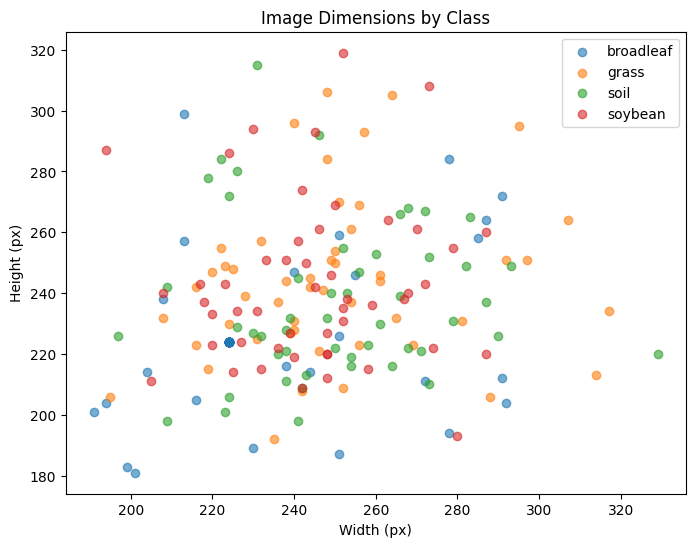

In [5]:
# Multivariate Non-Graphical Summary of Image Dimensions
summary_stats = df_shapes.groupby('class')[['height', 'width']].agg(['min', 'mean', 'max'])
print("Summary Statistics (Height and Width by Class):")
print(summary_stats)

# Multivariate Graphical Analysis - Scatter plot of sampled dimensions
plt.figure(figsize=(8,6))
for cls in classes:
    sub = df_shapes[df_shapes['class']==cls]
    plt.scatter(sub['width'], sub['height'], alpha=0.6, label=cls)
plt.xlabel("Width (px)"); plt.ylabel("Height (px)")
plt.title("Image Dimensions by Class"); plt.legend(); plt.show()

This dataset is imbalanced with soybean having 7,376 samples, while broadleaf, grass, and soil have 1,191, 3,520, and 3,249 images respectively. This will need to be corrected with class weighting or another method. 

Additionally, we have sampled the image dimensions by class and the dimensions range from 158 x 184 px to 404 x 324 px. This may need to be resized to a uniform input size such as 224 x 224 px, for example. 

#### Train Validation Split, Augmentation and class weighting to help with class imbalance


In [6]:
# Image processing config to resize for model input consistency
target_size = (224, 224)
batch_size = 32

In [7]:
# Handle broadleaf class imbalance by generating additional augmented images
# Uses aggressive augmentation to artificially increase the number of training samples for this under-represented class
# This creates synthesized variations of existing images by applying image transformations

# Directory where original broadleaf images are located
broadleaf_dir = os.path.join(base_dir, 'broadleaf')

# Directory to save augmented images (same class folder)
augmented_dir = broadleaf_dir

# Clean up old augmented images
for fname in os.listdir(broadleaf_dir):
    if fname.startswith('aug_broadleaf') and fname.endswith('.jpg'):
        os.remove(os.path.join(broadleaf_dir, fname))
print("Old augmented broadleaf images removed.")

# Create an ImageDataGenerator with aggressive augmentation
# Expose the model to broader intra-class variation
augment_broadleaf = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    shear_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Choose how many new images you want to generate (e.g., 500 more)
num_augmented = 1500
image_files = os.listdir(broadleaf_dir)
save_prefix = 'aug_broadleaf'

count = 0
for image_name in image_files:
    img_path = os.path.join(broadleaf_dir, image_name)
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in augment_broadleaf.flow(x, batch_size=1, save_to_dir=augmented_dir,
                                        save_prefix=save_prefix, save_format='jpg'):
        i += 1
        count += 1
        if i >= 1:
            break
        if count >= num_augmented:
            break
    if count >= num_augmented:
        break

print(f"Generated {count} new augmented broadleaf images.")

Old augmented broadleaf images removed.
Generated 1191 new augmented broadleaf images.


In [8]:
# ImageDataGenerator: Handles image preprocessing and augmentation across the classes, including brightness sensitivty
# This configuration is applied to both training and validation datasets (with validation_split)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

# Training generator: Loads training images with augmentations applied
train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator: Loads validation images (no augmentation, just rescaling)
val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 13169 images belonging to 4 classes.
Found 3291 images belonging to 4 classes.


The first number is the training set (80%).
The second number is the validation set (20%).

In [9]:
# Get the class labels for each image in the training set
labels = train_gen.classes

# Get mapping from class names to integer indices
class_indices = train_gen.class_indices

# Reverse the mapping to get index → class name
index_to_class = {v: k for k, v in class_indices.items()}

# Compute balanced class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Map weights to class index
class_weights = dict(zip(np.unique(labels), weights))

# Get mapping from index to class name
index_to_class = {v: k for k, v in train_gen.class_indices.items()}

# Manually boost broadleaf weight
for idx, name in index_to_class.items():
    if name == "broadleaf":
        class_weights[idx] *= 1.25  # boost by 25%

# Print updated weights
print("Updated class weights:")
for idx, weight in class_weights.items():
    class_name = index_to_class[idx]
    print(f"Index {idx}: {class_name:<10} → Weight: {weight:.3f}")

Updated class weights:
Index 0: broadleaf  → Weight: 2.222
Index 1: grass      → Weight: 1.169
Index 2: soil       → Weight: 1.266
Index 3: soybean    → Weight: 0.558


## Data Privacy 

Agricultural data does not contain personal identifying patient data or protected health info and data is not from a covered entity (such as hospital, clinical, financial institution); therefore HIPAA or personal protected data is not a concern.

However, one potential privacy risk lies in the geolocation metadata (EXIF data) embedded in image files, which may reveal where the image was captured. To address this, we include a verification and cleaning step to detect and remove any such metadata from .tif images.

In [10]:
# Track whether any metadata was found
found_metadata = False

# Iterate through all .tif files recursively
for img_path in base_dir.rglob("*.tif"):
    try:
        img = Image.open(img_path)
        if "exif" in img.info:
            print(f"Yes metadata: {img_path.name}")
            found_metadata = True
            # Strip metadata by saving a clean copy
            img_no_meta = Image.new(img.mode, img.size)
            img_no_meta.putdata(list(img.getdata()))
            img_no_meta.save(img_path)
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")

# If no metadata was found in any file
if not found_metadata:
    print("No .tif images with metadata found.")

No .tif images with metadata found.


### CNN (Convolutional Neural Network)

In [11]:
# Define CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Train the model with class weights  
#history = cnn_model.fit(
 #   train_gen,
 #   validation_data=val_gen,
  #  epochs=8,
#    class_weight=class_weights
#)

Epoch 1/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.6205 - loss: 0.9344 - val_accuracy: 0.8551 - val_loss: 0.4004
Epoch 2/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8519 - loss: 0.4305 - val_accuracy: 0.8687 - val_loss: 0.3562
Epoch 3/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.8726 - loss: 0.3703 - val_accuracy: 0.8739 - val_loss: 0.3238
Epoch 4/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8968 - loss: 0.3123 - val_accuracy: 0.9101 - val_loss: 0.2235
Epoch 5/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9112 - loss: 0.2669 - val_accuracy: 0.8988 - val_loss: 0.2531
Epoch 6/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9149 - loss: 0.2588 - val_accuracy: 0.9262 - val_loss: 0.1868
Epoch 7/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9251 - loss: 0.2406 - val_accuracy: 0.9222 - val_loss: 0.1902
Epoch 8/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9304 - loss: 0.2135 - val_accuracy: 0.

#### History Log Results of Training Model when first executed

Epoch 1/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.6205 - loss: 0.9344 - val_accuracy: 0.8551 - val_loss: 0.4004

Epoch 2/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8519 - loss: 0.4305 - val_accuracy: 0.8687 - val_loss: 0.3562

Epoch 3/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.8726 - loss: 0.3703 - val_accuracy: 0.8739 - val_loss: 0.3238

Epoch 4/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.8968 - loss: 0.3123 - val_accuracy: 0.9101 - val_loss: 0.2235

Epoch 5/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9112 - loss: 0.2669 - val_accuracy: 0.8988 - val_loss: 0.2531

Epoch 6/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9149 - loss: 0.2588 - val_accuracy: 0.9262 - val_loss: 0.1868

Epoch 7/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.9251 - loss: 0.2406 - val_accuracy: 0.9222 - val_loss: 0.1902

Epoch 8/8
412/412 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.9304 - loss: 0.2135 - val_accuracy: 0.9371 - val_loss: 0.1703

In [13]:
# Save the trained CNN model
cnn_model.save("cnn_model_epoch8.keras")
print("CNN model saved successfully.")

CNN model saved successfully.


### Load Pretrained Model
To avoid retraining after initial execution, download the pretrained model from Google Drive using the link below.
Save a copy to same local project folder as project notebook.

##### Link: [cnn_model_epoch8.keras](https://drive.google.com/file/d/1Wh0IRMk9Ch_nObGwF99CR7Zq7AqI2N3o/view?usp=sharing)


In [ ]:
# Automatically download the saved trained CNN model from Google Drive

# Check if model file exists
if not os.path.exists("cnn_model_epoch8.keras"):
    try:
        # Install gdown if needed
        import gdown
    except ImportError:
        !pip install gdown
        import gdown

    # Download using file ID
    file_id = "1Wh0IRMk9Ch_nObGwF99CR7Zq7AqI2N3o"
    gdown.download(id=file_id, output="cnn_model_epoch8.keras", quiet=False)

warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.saving.saving_lib')
# Load the model
cnn_model = load_model("cnn_model_epoch8.keras")
print("Model loaded successfully")


In [14]:
# History data of training model was retained since the model was saved for future loading to avoid training code re-execution
history_data = {
    'accuracy':     [0.6285, 0.8519, 0.8726, 0.8968, 0.9112, 0.9149, 0.9251, 0.9384],
    'val_accuracy': [0.8551, 0.8687, 0.8739, 0.9101, 0.8988, 0.9262, 0.9222, 0.9371],
    'loss':         [0.9344, 0.4305, 0.3703, 0.3123, 0.2669, 0.2588, 0.2406, 0.2135],
    'val_loss':     [0.4004, 0.3562, 0.3238, 0.2235, 0.2531, 0.1868, 0.1902, 0.1703]
}


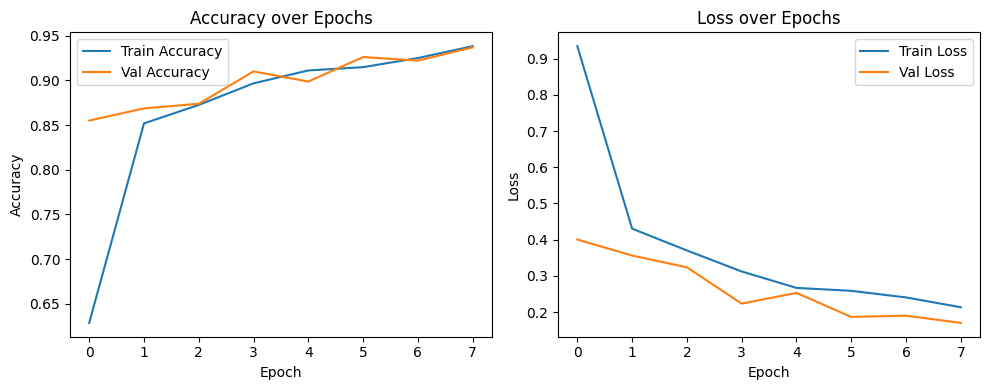

In [15]:
plt.figure(figsize=(10, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Plots show there is improvement in both training and validation accuracy and overall decrease in training and validation loss; this indicates model is learning effectively and generalizes well on unseen data with no signs of overfitting.


#### CNN Model Evaluation



In [16]:
# Evaluate trained CNN model on validation set

# Get true class labels and predicted labels
y_true_cnn = val_gen.classes
y_pred_cnn = cnn_model.predict(val_gen)  # Predict class probabilities for each validation image

# Get class predictions directly from argmax (no confidence threshold)
y_pred_labels_cnn = [np.argmax(probs) for probs in y_pred_cnn]

# Define expected labels and their target names
labels = [0, 1, 2, 3]
target_names = ["Broadleaf", "Grass", "Soil", "Soybean"]

# Print classification report
print("Classification Report:")
print(classification_report(y_true_cnn, y_pred_labels_cnn, labels=labels, target_names=target_names))

103/103 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step
Classification Report:
              precision    recall  f1-score   support

   Broadleaf       0.80      0.86      0.83       463
       Grass       0.87      0.85      0.86       704
        Soil       1.00      1.00      1.00       649
     Soybean       0.98      0.96      0.97      1475

    accuracy                           0.93      3291
   macro avg       0.91      0.92      0.92      3291
weighted avg       0.93      0.93      0.93      3291



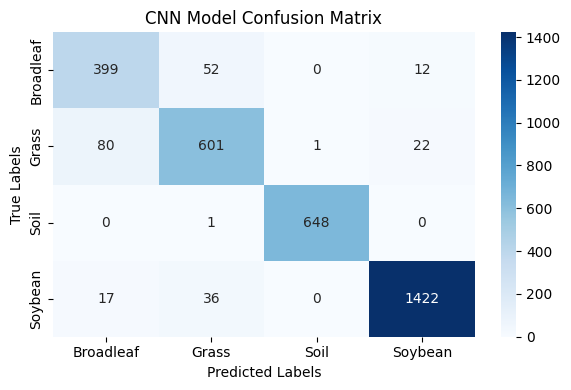

In [17]:
# Define all labels and their corresponding names
labels_all = [0, 1, 2, 3]
target_names = ["Broadleaf", "Grass", "Soil", "Soybean"]

# Compute confusion matrix with only valid labels
cnn_cm = confusion_matrix(y_true_cnn, y_pred_labels_cnn, labels=labels_all)

# Plot Confusion Matrix (cleaner version)
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("CNN Model Confusion Matrix")
plt.tight_layout()
plt.show()

Broadleaf is the most challenging class. Grass classifies mostly well with some confusion misclassifying as Broadleaf and Soybean. Soybean and Soil are the most confidentally predicted classes. Soybean is the best performing class.

## EfficientNetB0 Vs MobileNetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping


/Users/edgarrosales/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
from pathlib import Path

# Replace with your actual local dataset root if needed
dataset_root = Path.home() / ".cache" / "kagglehub" / "datasets" / "fpeccia" / "weed-detection-in-soybean-crops" / "versions" / "1"
image_folder = dataset_root / "dataset" / "dataset"

# Extract class names
class_names = sorted([folder.name for folder in image_folder.iterdir() if folder.is_dir()])
num_classes = len(class_names)
print(f"Detected {num_classes} classes: {class_names}")


Detected 4 classes: ['broadleaf', 'grass', 'soil', 'soybean']


In [ ]:
# EfficientNetB0-based model architecture
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Load EfficientNetB0 base without the classification layer
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze base model to use as a fixed feature extractor
base_model.trainable = False

# Build full model using Sequential API
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),             # Flatten spatial features to 1D
    layers.Dropout(0.3),                         # Dropout for regularization
    layers.Dense(num_classes, activation='softmax')  # Final classification layer
])

# Print model architecture summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
# ⚙️ Compile the model using Adam optimizer and sparse categorical loss
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # because labels are integers, not one-hot
    metrics=['accuracy']
)


In [ ]:
# dataset path
dataset_root = Path.home() / ".cache" / "kagglehub" / "datasets" / "fpeccia" / "weed-detection-in-soybean-crops" / "versions" / "1"
image_folder = dataset_root / "dataset" / "dataset"

# class names and label encoding
class_names = sorted([folder.name for folder in image_folder.iterdir() if folder.is_dir()])
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

# image paths and labels
image_paths = []
image_labels = []

for cls in class_names:
    cls_path = image_folder / cls
    for img_file in cls_path.glob("*.tif"):
        image_paths.append(str(img_file))
        image_labels.append(class_to_idx[cls])

# training and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, stratify=image_labels, random_state=42
)

# load and preprocess a TIFF image
def load_tiff(path, label):
    def _read_img(path_str):
        img = tiff.imread(path_str.decode("utf-8"))
        return img

    img = tf.numpy_function(_read_img, [path], tf.uint8)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


# tf.data.Dataset pipelines
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_tiff, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_tiff, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# model with early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

# early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 134s 346ms/step - accuracy: 0.4830 - loss: 1.2387 - val_accuracy: 0.4811 - val_loss: 1.2211
Epoch 2/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 127s 329ms/step - accuracy: 0.4892 - loss: 1.2265 - val_accuracy: 0.4811 - val_loss: 1.2326
Epoch 3/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 127s 329ms/step - accuracy: 0.4880 - loss: 1.2260 - val_accuracy: 0.4811 - val_loss: 1.2402
Epoch 4/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 128s 331ms/step - accuracy: 0.4831 - loss: 1.2274 - val_accuracy: 0.4811 - val_loss: 1.2207
Epoch 5/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 127s 329ms/step - accuracy: 0.4914 - loss: 1.2149 - val_accuracy: 0.4811 - val_loss: 1.2141
Epoch 6/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 127s 329ms/step - accuracy: 0.4855 - loss: 1.2230 - val_accuracy: 0.4811 - val_loss: 1.2174
Epoch 7/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 127s 329ms/step - accuracy: 0.4898 - loss: 1.2172 - val_accuracy: 0.4811 - val_loss: 1.2186
Epoch 8/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 129s 332ms/step - accuracy: 0.4866 -

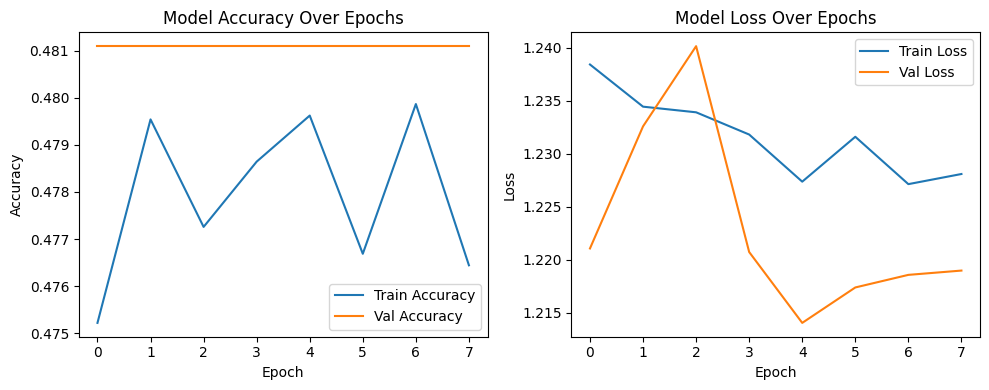

In [ ]:
# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


📋 Classification Report:
              precision    recall  f1-score   support

   broadleaf       0.00      0.00      0.00       238
       grass       0.00      0.00      0.00       704
        soil       0.00      0.00      0.00       650
     soybean       0.48      1.00      0.65      1476

    accuracy                           0.48      3068
   macro avg       0.12      0.25      0.16      3068
weighted avg       0.23      0.48      0.31      3068



2025-07-25 16:04:33.666245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/edgarrosales/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/edgarrosales/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/edgarrosales/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s

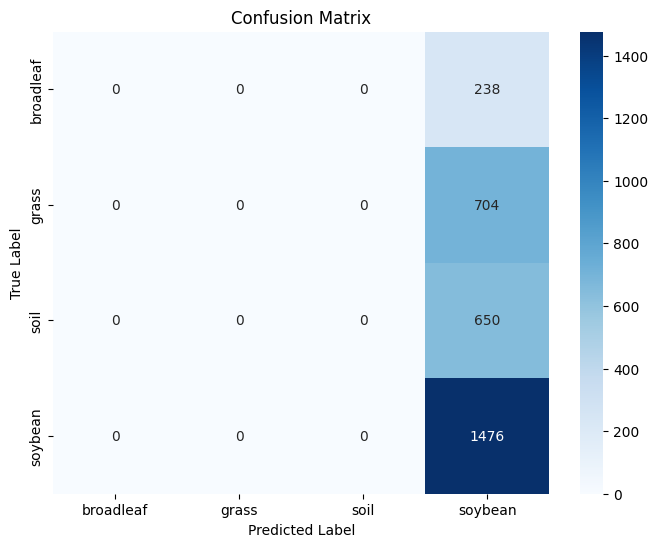

In [ ]:
y_true = []
y_pred = []

# loop validation data
for images, labels in val_ds.unbatch():
    preds = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_true.append(labels.numpy())  # 🔁 FIXED: use label directly
    y_pred.append(np.argmax(preds))  # model output is softmax probs

# classification report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Un Freesign EffNet

In [ ]:
# unfreeze the base model
base_model.trainable = True

# recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# convert class labels to integer indices
class_indices = {name: idx for idx, name in enumerate(class_names)}

# all labels from val_ds to get the class distribution
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

# flatten one-hot encoded labels if needed
if len(all_labels[0].shape) > 0:
    all_labels = [np.argmax(label) for label in all_labels]

# class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# map to dictionary format expected by model.fit
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(3.2182581322140607), 1: np.float64(1.0891335227272727), 2: np.float64(1.1800692574066949), 3: np.float64(0.5198305084745762)}


In [ ]:
# Fine-tune the model with class weights
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)


Epoch 1/10


384/384 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.3547 - loss: 1.1364 - val_accuracy: 0.5525 - val_loss: 1.1894
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.9241 - loss: 0.2989 - val_accuracy: 0.9674 - val_loss: 0.2445
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.9743 - loss: 0.1240 - val_accuracy: 0.9821 - val_loss: 0.0935
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.9788 - loss: 0.0854 - val_accuracy: 0.9254 - val_loss: 0.2392
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.9829 - loss: 0.0651 - val_accuracy: 0.9664 - val_loss: 0.1602
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 572s 1s/step - accuracy: 0.9868 - loss: 0.0459 - val_accuracy: 0.9928 - val_loss: 0.0380
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.9882 - loss: 0.0418 - val_accuracy: 0.9941 - val_loss: 0.0263
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - accuracy: 0.9899 - loss: 0.0355 - val_accuracy: 0.996

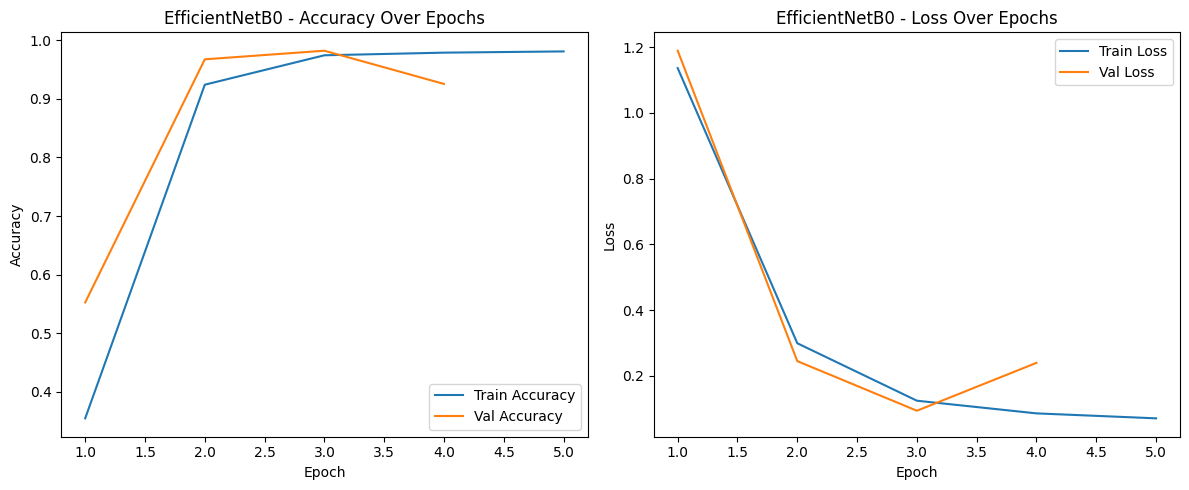

In [ ]:
# simulated history.history for EfficientNetB0 
effnet_history = {
    'accuracy': [0.3547, 0.9241, 0.9743, 0.9788, 0.9809],
    'val_accuracy': [0.5525, 0.9674, 0.9821, 0.9254],
    'loss': [1.1364, 0.2989, 0.1240, 0.0854, 0.0703],
    'val_loss': [1.1894, 0.2445, 0.0935, 0.2392]
}

epochs = range(1, len(effnet_history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, effnet_history['accuracy'], label='Train Accuracy')
plt.plot(epochs[:len(effnet_history['val_accuracy'])], effnet_history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, effnet_history['loss'], label='Train Loss')
plt.plot(epochs[:len(effnet_history['val_loss'])], effnet_history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


📋 Classification Report:
              precision    recall  f1-score   support

   broadleaf       0.99      0.99      0.99       238
       grass       1.00      1.00      1.00       704
        soil       1.00      1.00      1.00       650
     soybean       1.00      1.00      1.00      1476

    accuracy                           1.00      3068
   macro avg       1.00      1.00      1.00      3068
weighted avg       1.00      1.00      1.00      3068



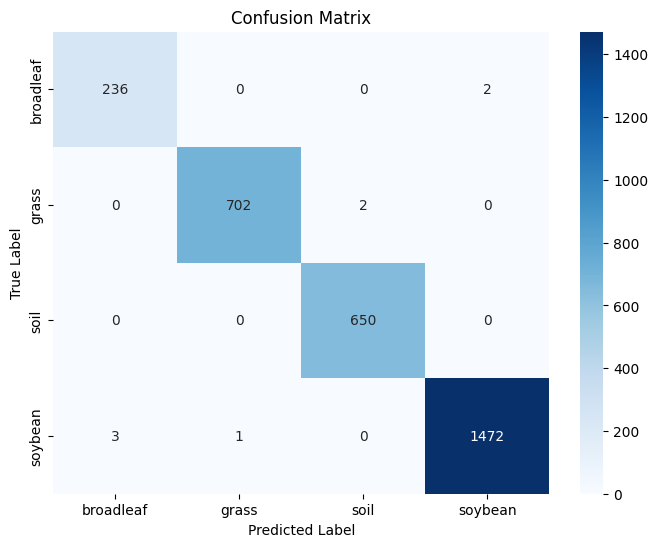

In [ ]:
# reset lists
y_true = []
y_pred = []

# predictions on validation set
for images, labels in val_ds.unbatch():
    preds = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds))

# classification Report
print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Load MobileNetV2 base model (exclude top layer)
mobilenet_base = MobileNetV2(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')
mobilenet_base.trainable = False  # Freeze base

# model
mobilenet_model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# compile
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# convert integer labels to one-hot encoding
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)


TypeError: in user code:

    File "/var/folders/8s/0dk3dwds4ln63bdvfx33lm9m0000gp/T/ipykernel_996/376748024.py", line 3, in one_hot_encode  *
        label = tf.one_hot(label, depth=num_classes)

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: uint8, int8, int32, int64


In [ ]:
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
# train with early stopping and class weights
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

mobilenet_history = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)


Epoch 1/10


384/384 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.8412 - loss: 0.4176 - val_accuracy: 0.9801 - val_loss: 0.0663
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 80s 205ms/step - accuracy: 0.9710 - loss: 0.0786 - val_accuracy: 0.9804 - val_loss: 0.0568
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 80s 207ms/step - accuracy: 0.9805 - loss: 0.0572 - val_accuracy: 0.9889 - val_loss: 0.0371
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 79s 204ms/step - accuracy: 0.9839 - loss: 0.0459 - val_accuracy: 0.9876 - val_loss: 0.0412
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 80s 204ms/step - accuracy: 0.9834 - loss: 0.0449 - val_accuracy: 0.9919 - val_loss: 0.0311
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 80s 206ms/step - accuracy: 0.9866 - loss: 0.0379 - val_accuracy: 0.9899 - val_loss: 0.0324
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 80s 207ms/step - accuracy: 0.9866 - loss: 0.0377 - val_accuracy: 0.9909 - val_loss: 0.0294
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 80s 205ms/step - accuracy: 0.9859 - loss: 0.0348 - val

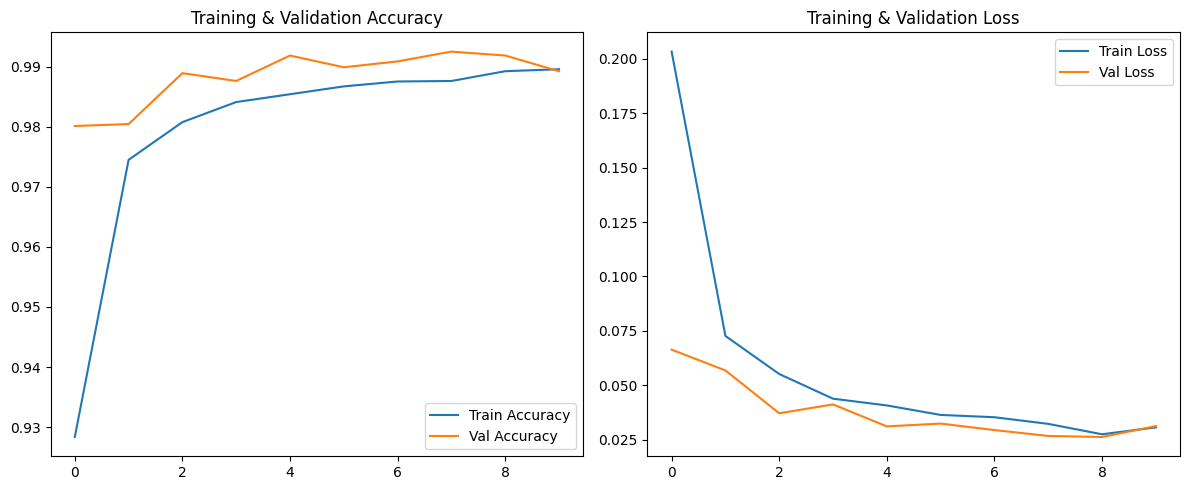

In [ ]:
acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:

              precision    recall  f1-score   support

   broadleaf       0.98      0.98      0.98       238
       grass       0.98      1.00      0.99       704
        soil       0.99      0.99      0.99       650
     soybean       1.00      0.99      0.99      1476

    accuracy                           0.99      3068
   macro avg       0.99      0.99      0.99      3068
weighted avg       0.99      0.99      0.99      3068



2025-07-25 18:26:55.268040: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


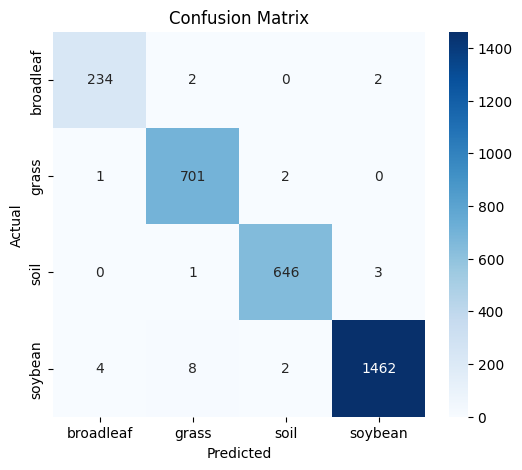

In [ ]:
# get truth and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    pred = mobilenet_model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_true.append(np.argmax(labels.numpy()))
    y_pred.append(np.argmax(pred))

# classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
